# Introduciton to Lotka-Volterra Competition

In [1]:
using Parameters
using DifferentialEquations
using ForwardDiff
using Plots
pyplot();

# Introduction/Overview
This notebook is simply looking at the two species L-V competiti9on model. Here, we are exploring
the geometry and dynamics of this model.

# Model and Equilibria
The model we will use is the classical LV competition model:

In [2]:
# Inplace definition (the `du` array is passed to the function and changed), the default way to
# define this in Julia.
function lv_comp(du, u, p, t)
    @unpack r1, r2, α12, α21, K1, K2 = p
    du[1] = u[1] * r1 * (1 - (u[1] + α12 * u[2]) / K1)
    du[2] = u[2] * r2 * (1 - (u[2] + α21 * u[1]) / K2)
    return
end

# Make a version that allocates the output `du`, useful for symbolic calculations
function lv_comp(u, p, t)
    du = similar(u)
    lv_comp(du, u, p, t)
    return du
end

lv_comp (generic function with 2 methods)

# Model Parameters

In [3]:
@with_kw mutable struct LVPar
    α12 = 0.8
    α21 = 0.3
    r1 = 1.0
    r2 = 2.0
    K1 = 1.5
    K2 = 1.0
end

Main.##476.LVPar

# Evaluationg the model -- time series

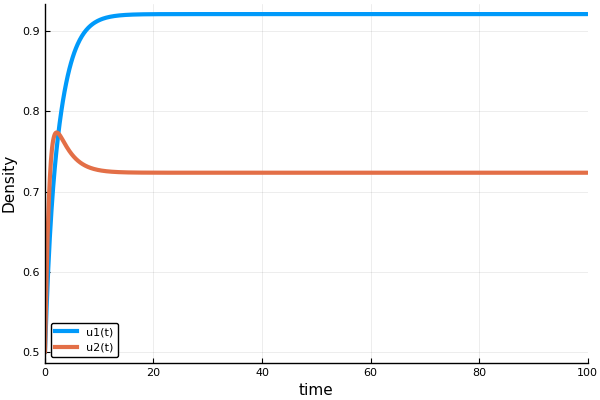

In [4]:
let
    u0 = [0.5, 0.5]
    t_span = (0.0, 100.0)
    p = LVPar()

    prob = ODEProblem(lv_comp, u0, t_span, p)
    sol = solve(prob, reltol = 1e-8)

    plot(sol)
    xlabel!("time")
    ylabel!("Density")
end

# Equilibria and Isoclines
From the above equations we can generate the Jacobian:

Make a numerical (not symbolic version using the ForwardDiff.jl library.
This is what you will want to do most of the time)

In [5]:
jac(u, p) = ForwardDiff.jacobian(u -> lv_comp(u, p, NaN), u)

jac (generic function with 1 method)

Here we have the jacobian evaluated at the point `u = [0.5, 0.5]`, with the parameter set `par`

In [6]:
jac([0.5, 0.5], LVPar())

2×2 Array{Float64,2}:
  0.0666667  -0.266667
 -0.3        -0.3     

First solve for $f_1$ and $f_2$ to determine when functions are equal to 0 (i.e., when $du_1/dt$
and $du_2/dt = 0$). These are known as the isoclines, or nullclines, and describe the set of
solutions when $u_1$ and $u_2$ do not change.

In [7]:
# We need to use a library for Symbolic calculations, a very common one is SymPy from the python
# language. Luckily Julia has excellent support for it.
using SymPy

We want to deal with all of these as symbolic variables, which are not the default type in Julia,
unlike Mathematica.

In [8]:
@vars u1 u2
@vars r1 r2 a12 a21 K1 K2

(r1, r2, a12, a21, K1, K2)

We need to make a symbolic parameter list, as `LVPar` is numeric

In [9]:
spar = Dict(
    :α12 => a12,
    :α21 => a21,
    :r1 => r1,
    :r2 => r2,
    :K1 => K1,
    :K2 => K2);

we need to make symbolic versions of the model equations. We do this by calling the function with
the symbolic parameters. the last parameter could be anythign as the time (`t`) argument is not
used. I have set it to `NaN` which is a name for not a number.

In [10]:
f1, f2 = lv_comp([u1, u2], spar, NaN)

2-element Array{Sym,1}:
 r1*u1*(1 - (a12*u2 + u1)/K1)
 r2*u2*(1 - (a21*u1 + u2)/K2)

In [11]:
sympy.solve(f1, u1)

2-element Array{Sym,1}:
           0
 K1 - a12*u2

In [12]:
sympy.solve(f1, u2)

1-element Array{Sym,1}:
 (K1 - u1)/a12

In [13]:
sympy.solve(f2, u1)

1-element Array{Sym,1}:
 (K2 - u2)/a21

In [14]:
sympy.solve(f2, u2)

2-element Array{Sym,1}:
           0
 K2 - a21*u1

We want to solve our equations for $u_1$ so that we can plot the isoclines as a function of  $u_1$
($u_1$ on the y-axis), but here I am keeping all possible solutions, with respect to both $u_1$
and $u_2$. You should be able to see that the first two solutions ($u_1 = K_1 - \alpha_{12}u_2$
and $u_2 = (K_1 - u_1)/\alpha_{12}$) are equivalent.

The solutions $u_1 = K_1 - \alpha_{12}u_2$ and $u_1 = (K_2 - u_2)/\alpha_{21}$ are the equations
for our isoclines for $du_1/dt = 0$ and $du_2/dt = 0$, respectively. We can find the interior
equilibrium where these lines intersect (i.e., both $u_1$ and $u_2$ do not change). In this case
we get one interior equilibrium, but note that in more complicated models we can get more interior
equilibria.

# Now plot the isoclines
We will again use the manipulate function to see how our parameters change the isoclines. This can
immediately tell us a lot about our equilibria and stability.

In [15]:
function iso1(u2, p)
    @unpack α12, K1 = p
    return K1 - α12 * u2 / K1
end

iso1 (generic function with 1 method)

In [16]:
function iso2(u2, p)
    @unpack α21, K2 = p
    return (K2 - u2) / α21
end

iso2 (generic function with 1 method)

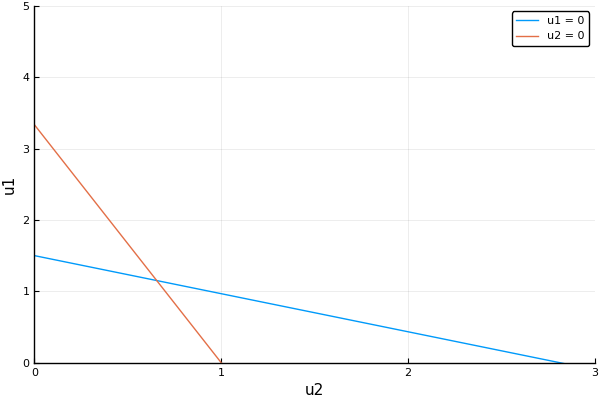

In [17]:
let
    p = LVPar()
    u2s = range(0, 5, length = 100)

    fig = plot(u2s, [iso1(u2, p) for u2 in u2s], label = "u1 = 0")
    plot!(u2s, [iso2(u2, p) for u2 in u2s], label = "u2 = 0")
    xlims!(0, 3)
    ylims!(0, 5)
    xlabel!("u2")
    ylabel!("u1")
end

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*